In [18]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

import numpy as np

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns

sns.set_context(context="poster", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Download Data

## Mutual Information

In [2]:
from pysim.data.information.gaussian import generate_gaussian_mi_data
from pysim.data.information.studentt import generate_studentt_mi_data

In [3]:
n_samples = 50_000
n_features = 2
seed = 1
df = 5

# create seed (trial number)
res_dict = generate_studentt_mi_data(
    n_samples=n_samples, n_features=n_features, df=df, seed=seed,
)
res_dict = generate_gaussian_mi_data(
    n_samples=n_samples, n_features=n_features, seed=seed,
)

In [4]:
res_dict.MI

0.166460644947092

## Estimators

In [5]:
from pysim.information.gaussian import gauss_entropy_multi
from pysim.information.knn import knn_entropy, knn_entropy_npeet
from pysim.information.mutual import multivariate_mutual_information
import time


def get_mi_estimators(X, Y):

    t0 = time.time()
    res = multivariate_mutual_information(X=X.copy(), Y=Y.copy(), f=gauss_entropy_multi)
    print(f"Gaussian: {res['mi']:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    res = multivariate_mutual_information(
        X=X.copy(), Y=Y.copy(), f=knn_entropy, n_neighbors=10, n_jobs=-1
    )
    print(f"KNN (Neighbours):  {res['mi']:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    res = multivariate_mutual_information(
        X=X.copy(), Y=Y.copy(), f=knn_entropy_npeet, n_neighbors=10, n_jobs=-1
    )
    print(f"KNN (epsilon):  {res['mi']:.4f} | Time: {time.time()-t0:.4f} secs")

In [6]:
get_mi_estimators(res_dict.X, res_dict.Y)

Gaussian: 0.1715 | Time: 0.0277 secs
KNN (Neighbours):  0.1990 | Time: 2.4186 secs
KNN (epsilon):  -0.1337 | Time: 1.1025 secs


## Demo Experiment

In [52]:
n_samples = [
    500,
    1_000,
    5_000,
]  # 10_000, 50_000, 100_000]  # 10_000, 30_000, 50_000]
n_features = [10]  # [2, 3, 10, 50, 100]
n_trials = 10
df = 3

In [53]:
from tqdm.notebook import tqdm, trange
import pandas as pd
import itertools

iteration = itertools.count()


all_stats = pd.DataFrame()

pbar_features = tqdm(n_features, leave=True)

for i_features in pbar_features:

    pbar_features.set_description(f"Features: {i_features}")

    results = {}

    pbar_samples = tqdm(n_samples, leave=False)

    for i_samples in pbar_samples:

        pbar_samples.set_description(f"Samples: {i_samples}")

        pbar_trials = trange(n_trials, leave=False)

        for i_trial in pbar_trials:

            pbar_trials.set_description(f"Trials: {i_trial} | Method: GT")

            # generate data
            res_dict = generate_studentt_mi_data(
                n_samples=i_samples, n_features=i_features, df=df, seed=i_trial,
            )
            #             res_dict = generate_gaussian_mi_data(
            #                 n_samples=i_samples, n_features=i_features, seed=i_trial,
            #             )
            results = {
                "method": "truth",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "mi": res_dict.MI,
            }
            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )

            # ======================
            # Gaussian Estimation
            # ======================
            pbar_trials.set_description(f"Trials: {i_trial} | Method: Gaussian")
            output = multivariate_mutual_information(
                X=res_dict.X.copy(), Y=res_dict.Y.copy(), f=gauss_entropy_multi
            )
            results = {
                "method": "gaussian",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "mi": output["mi"],
            }

            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )
            # ==========================
            # KNN estimated (Neighbors)
            # ==========================

            pbar_trials.set_description(f"Trials: {i_trial} | Method: KNN (Neighbors)")

            output = multivariate_mutual_information(
                X=res_dict.X.copy(),
                Y=res_dict.Y.copy(),
                f=knn_entropy,
                n_neighbors=10,
                base=2,
            )
            results = {
                "method": "knn",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "mi": output["mi"],
            }

            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )

            # ==========================
            # KNN estimated (Epsilon)
            # ==========================
            pbar_trials.set_description(
                f"Trials: {i_trial} | Method: KNN (Epsilon-Ball)"
            )

            output = multivariate_mutual_information(
                X=res_dict.X.copy(),
                Y=res_dict.Y.copy(),
                f=knn_entropy_npeet,
                n_neighbors=10,
                base=2,
            )
            results = {
                "method": "knn_tree",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "mi": output["mi"],
            }

            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [54]:
all_stats.head()

,method,n_samples,n_features,trial,mi
0,truth,500,10,0,5.189690
1,gaussian,500,10,0,4.796933
2,knn,500,10,0,0.882974
3,knn_tree,500,10,0,-2.630373
4,truth,500,10,1,3.134896


In [55]:
all_stats_ = all_stats.copy()
all_stats_["algorithm"] = all_stats_["method"]
all_stats_ = all_stats_.drop(["method"], axis=1)

In [56]:
all_stats_ = all_stats_.set_index(["n_samples", "n_features", "trial", "algorithm"])

In [57]:
stats_ds = all_stats_.to_xarray()

In [58]:
stats_ds

<xarray.Dataset>
Dimensions:     (algorithm: 4, n_features: 1, n_samples: 3, trial: 10)
Coordinates:
  * n_samples   (n_samples) int64 500 1000 5000
  * n_features  (n_features) int64 10
  * trial       (trial) int64 0 1 2 3 4 5 6 7 8 9
  * algorithm   (algorithm) object 'gaussian' 'knn' 'knn_tree' 'truth'
Data variables:
    mi          (n_samples, n_features, trial, algorithm) float64 4.797 ... 3...

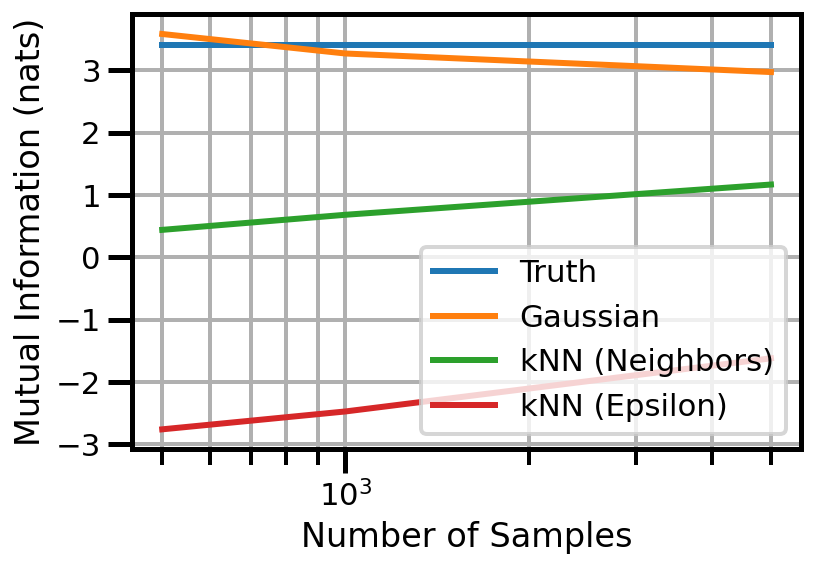

In [59]:
fig, ax = plt.subplots()


stats_ds.sel(n_features=n_features, algorithm="truth").mean(["trial"]).mi.plot(
    ax=ax, label="Truth"
)
stats_ds.sel(n_features=n_features, algorithm="gaussian").mean(["trial"]).mi.plot(
    ax=ax, label="Gaussian"
)
stats_ds.sel(n_features=n_features, algorithm="knn").mean(["trial"]).mi.plot(
    ax=ax, label="kNN (Neighbors)"
)
stats_ds.sel(n_features=n_features, algorithm="knn_tree").mean(["trial"]).mi.plot(
    ax=ax, label="kNN (Epsilon)"
)
# t = stats_ds.sel(n_features=10, algorithm="knn_tree").mean(["trial"]).mi
# t *= np.log(2)
# t.plot(ax=ax, label="kNN (Epsilon)", linewidth=5, linestyle="--")

ax.set(
    xlabel="Number of Samples",
    ylabel="Mutual Information (nats)",
    title="",
    xscale="log",
)
ax.grid(
    True, which="both",
)
ax.legend()
plt.show()

In [47]:
def percent_error(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon))
    return mape


def get_mean_std(ds):
    mean = ds.mean(["trial"])
    std = 1.96 * ds.std(["trial"])
    return mean, std

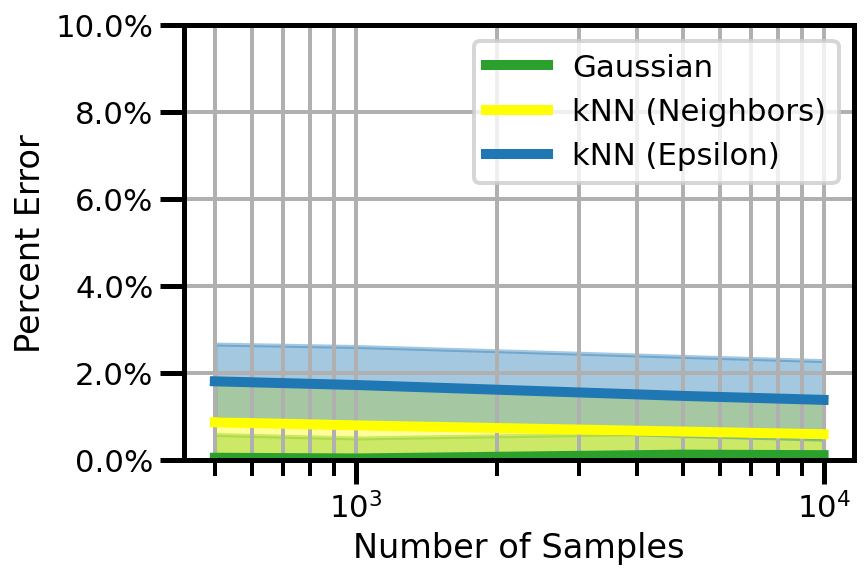

In [49]:
fig, ax = plt.subplots()

real = stats_ds.sel(n_features=10, algorithm="truth").mean(["trial"]).mi

# stats_ds.sel(n_features=10, algorithm="truth_nats").mean(["trial"]).H.plot(
#     ax=ax, label="Truth", linewidth=5, color="black"
# )

# ==========================
# GAUSSIAN ESTIMATE
# ==========================
mu, std = get_mean_std(stats_ds.sel(n_features=10, algorithm="gaussian").mi)

# calculate percent error
err_mu = percent_error(real, mu)
err_std = percent_error(real, std)

x_data = err_mu.coords["n_samples"].values
y_mu = err_mu.values
ub = y_mu + err_std.values.ravel()
lb = y_mu - err_std.values.ravel()

ax.plot(x_data, y_mu, linewidth=5, linestyle="-", color="tab:green", label="Gaussian")
ax.fill_between(x_data, lb, ub, alpha=0.4, color="tab:green")


# ==========================
# KNN (NEIGHBOURS) ESTIMATE
# ==========================
mu, std = get_mean_std(stats_ds.sel(n_features=10, algorithm="knn").mi)

# calculate percent error
err_mu = percent_error(real, mu)
err_std = percent_error(real, std)

x_data = err_mu.coords["n_samples"].values
y_mu = err_mu.values
ub = y_mu + err_std.values.ravel()
lb = y_mu - err_std.values.ravel()

ax.plot(
    x_data, y_mu, linewidth=5, linestyle="-", color="Yellow", label="kNN (Neighbors)"
)
ax.fill_between(x_data, lb, ub, alpha=0.4, color="Yellow")


# ==========================
# KNN (EPSILON) ESTIMATE
# ==========================
mu, std = get_mean_std(stats_ds.sel(n_features=10, algorithm="knn_tree").mi)

# calculate percent error
err_mu = percent_error(real, mu)
err_std = percent_error(real, std)

x_data = err_mu.coords["n_samples"].values
y_mu = err_mu.values
ub = y_mu + err_std.values.ravel()
lb = y_mu - err_std.values.ravel()

ax.plot(
    x_data, y_mu, linewidth=5, linestyle="-", color="tab:blue", label="kNN (Epsilon)"
)
ax.fill_between(x_data, lb, ub, alpha=0.4, color="tab:blue")


ax.set(
    xlabel="Number of Samples",
    ylabel="Percent Error",
    title="",
    xscale="log",
    ylim=[0, 10],
)
import matplotlib.ticker as mtick

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True, which="both")
ax.legend()
plt.show()